In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

**Initial Steps**
1. Check data types - seperate numerical from caegorical
2. Preprocessing - Impute numerical from `sklearn.impute`, encode categorical from `sklearn.preprocessing`. Classes - SimpleImputer, OrdinalEncoder, OneHotEncoder

    When using one hot encoding, remember to set `handle_unknown` parameter to `ignore` to sort out the entries that weren't seen during training and `sparse` to `False` to return the outcome as a numpy array. Also return column names after imputation.
3. Set training and test data
4. Standardize the data
5. Pass the data into model
6. Predict and check accuracy
7. Fine tune

In [5]:
from sklearn.impute import SimpleImputer

In [6]:
raw_data = pd.read_csv(".\\Loan Prediction\\RawData.csv")
# test_data = pd.read_csv(".\\Loan Prediction\\TestData.csv")

In [7]:
raw_data.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Setting X and y for splitting into train and testing datasets

In [9]:
y = raw_data.Loan_Status.copy()
raw_data.drop(['Loan_ID', 'Loan_Status'], axis=1, inplace=True)
X = raw_data.copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split (X,y, train_size=0.8, test_size = 0.2, random_state=42) 

In [14]:
categorical_columns = list(X_train.columns[X_train.dtypes == 'object'])

In [15]:
numerical_columns = list(X_train.columns[X_train.dtypes == 'int64']) + list(X_train.columns[X_train.dtypes == 'float64']) 

numerical_cols_missing_vals = [col for col in numerical_columns if X_train[numerical_columns][col].isnull().any()]

X_train_numerical_missing_vals = X_train [numerical_cols_missing_vals].copy()

**Imputing** fields with nulls in the numerical table with median value. Avoiding mean in case there are outliers in the data.

In [16]:
imputer = SimpleImputer(strategy = 'median')

In [17]:
imputed_X_train_numerical_missing_vals_table = imputer.fit_transform(X_train_numerical_missing_vals)

numerical_imputed = pd.DataFrame(imputed_X_train_numerical_missing_vals_table)

numerical_imputed.columns = X_train_numerical_missing_vals.columns

Lets get the **numerical fields with no nulls** and join them with the imputed fields to gt a complete nuemrical table

In [18]:
numerical_non_null_cols = list(set(numerical_columns) - set(numerical_cols_missing_vals))

numerical_non_null = X_train[numerical_non_null_cols]

In [19]:
numerical_non_null.reset_index(inplace=True, drop=True)

numerical_imputed.reset_index(inplace=True, drop=True)

In [20]:
numerical_table = pd.concat([numerical_non_null, numerical_imputed], axis=1)

In [21]:
numerical_table

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,6000,2250.0,265.0,360.0,1.0
1,2958,2900.0,131.0,360.0,1.0
2,6250,1695.0,210.0,360.0,1.0
3,2083,3150.0,128.0,360.0,1.0
4,4166,0.0,98.0,360.0,0.0
...,...,...,...,...,...
486,1875,1875.0,97.0,360.0,1.0
487,11417,1126.0,225.0,360.0,1.0
488,3237,0.0,30.0,360.0,1.0
489,10047,0.0,129.0,240.0,1.0


For **missing values** in **categorical fields**, we will **impute using most frequent**

In [22]:
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [23]:
categorical_cols_with_missing_vals = [col for col in categorical_columns if X_train[categorical_columns][col].isnull().any()]

categorical_data_missing_vals_table = X_train[categorical_cols_with_missing_vals].copy()

imputed_X_train_categorical_vals_table = categorical_imputer.fit_transform(categorical_data_missing_vals_table)

In [24]:
categorical_imputed = pd.DataFrame(imputed_X_train_categorical_vals_table)

categorical_imputed.columns = categorical_data_missing_vals_table.columns

categorical_non_null_cols = list(set(categorical_columns) - set(categorical_cols_with_missing_vals))

categorical_non_null = X_train [categorical_non_null_cols]

In [25]:
categorical_non_null.reset_index(inplace=True, drop=True)
categorical_imputed.reset_index(inplace=True, drop=True)

In [26]:
categorical_table = pd.concat([categorical_non_null, categorical_imputed], axis=1)

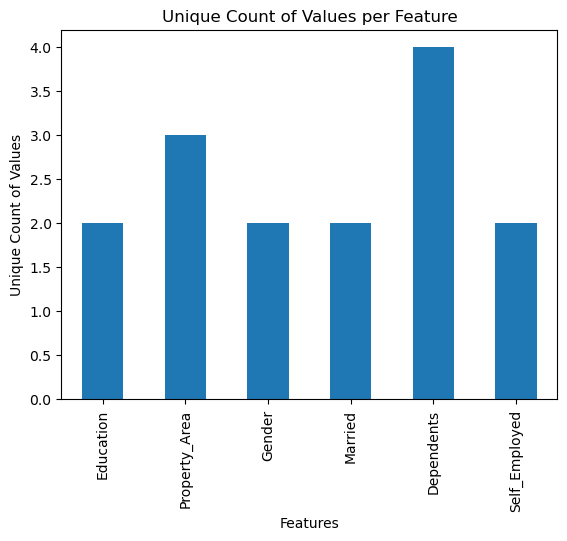

In [27]:
categorical_table.nunique().plot(kind='bar', stacked=True)
plt.xlabel('Features')
plt.ylabel('Unique Count of Values')
plt.title('Unique Count of Values per Feature')
plt.show()

The categorical features have few unique values, meaning we can manually code the text into numbers instead of using encoders. 
This mights still be time consuming given that we will have to do it one column at a time. Lets use encoding libraries

In [28]:
unique_values = pd.unique(categorical_table.values.ravel('K'))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_values)))
color_map = dict(zip(unique_values, colors))

In [29]:
unique_counts = categorical_table.apply(lambda x: x.value_counts()).fillna(0).astype(int)

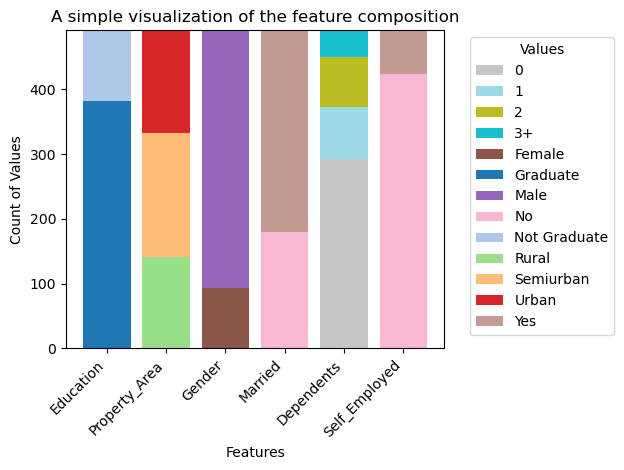

In [30]:
fig, ax = plt.subplots()

bottom = np.zeros(len(unique_counts.columns))
for value in unique_counts.index:
    ax.bar(unique_counts.columns, unique_counts.loc[value], bottom=bottom, color=color_map[value], label=value)
    bottom += unique_counts.loc[value]

plt.xlabel('Features')
plt.ylabel('Count of Values')
plt.title('A simple visualization of the feature composition')

# Moving the legend outside of the plot
plt.legend(title='Values', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjusting layout to make room for rotated labels
plt.show()

In [31]:
from sklearn.preprocessing import OrdinalEncoder

In [32]:
encoder = OrdinalEncoder()

In [33]:
categorical_tableB= categorical_table.copy()

categorical_tableB = encoder.fit_transform(categorical_tableB)

categorical_tableB = pd.DataFrame(categorical_tableB)

categorical_tableB.columns = categorical_table.columns

### Dealing With Numerical and Categorical Features In The Test Dataset

In [34]:
numerical_columns_X_test = list(X_test.columns[X_test.dtypes == 'int64']) + list(X_test.columns[X_test.dtypes == 'float64']) 

numerical_cols_missing_vals_X_test = [col for col in numerical_columns_X_test if X_test[numerical_columns_X_test][col].isnull().any()]

numerical_missing_vals_X_test = X_test [numerical_cols_missing_vals_X_test].copy()

In [35]:
numerical_missing_vals_X_test

,LoanAmount,Loan_Amount_Term,Credit_History
350,228.0,360.0,1.0
377,130.0,360.0,NaN
163,158.0,360.0,1.0
609,71.0,360.0,1.0
132,70.0,360.0,1.0
...,...,...,...
231,42.0,180.0,1.0
312,56.0,360.0,1.0
248,123.0,480.0,1.0
11,109.0,360.0,1.0


In [36]:
imputed_X_test_numerical_missing_vals_table = imputer.transform(numerical_missing_vals_X_test)

numerical_imputed_X_test = pd.DataFrame(imputed_X_test_numerical_missing_vals_table)

numerical_imputed_X_test.columns = numerical_missing_vals_X_test.columns

In [37]:
numerical_non_null_cols_X_test = list(set(numerical_columns_X_test) - set(numerical_cols_missing_vals_X_test))

numerical_non_null_X_test = X_test[numerical_non_null_cols_X_test]

In [38]:
numerical_non_null_X_test.reset_index(inplace=True, drop=True)
numerical_imputed_X_test.reset_index(inplace=True,drop=True)

In [39]:
numerical_table_X_test = pd.concat([numerical_non_null_X_test, numerical_imputed_X_test], axis=1)

In [40]:
categorical_columns_X_test = list(X_test.columns[X_test.dtypes == 'object'])

In [41]:
categorical_cols_with_missing_vals_X_test = [col for col in categorical_columns if X_test[categorical_columns][col].isnull().any()]

categorical_data_missing_vals_table_X_test = X_test[categorical_cols_with_missing_vals_X_test].copy()

imputed_X_test_categorical_vals_table = categorical_imputer.transform(categorical_data_missing_vals_table_X_test)

In [42]:
categorical_imputed_X_test = pd.DataFrame(imputed_X_test_categorical_vals_table)

categorical_imputed_X_test.columns = categorical_data_missing_vals_table_X_test.columns

categorical_non_null_cols_X_test = list(set(categorical_columns_X_test) - set(categorical_cols_with_missing_vals_X_test))

categorical_non_null_X_test = X_test [categorical_non_null_cols_X_test]

In [43]:
categorical_non_null_X_test.reset_index(inplace=True, drop=True)
categorical_imputed_X_test.reset_index(inplace=True,drop=True)

In [44]:
categorical_table_X_test = pd.concat([categorical_non_null_X_test, categorical_imputed_X_test], axis=1)

In [45]:
categorical_tableB_X_test = categorical_table_X_test.copy()

categorical_tableB_X_test = encoder.transform(categorical_tableB_X_test)

categorical_tableB_X_test = pd.DataFrame(categorical_tableB_X_test)

categorical_tableB_X_test.columns = categorical_table_X_test.columns

**Merging the numerical and categorical tables needed for training and testing**

In [46]:
test_table = pd.concat([numerical_table_X_test, categorical_tableB_X_test], axis=1)

In [47]:
X_train_imputed = pd.concat([numerical_table, categorical_tableB], axis=1)

In [48]:
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Y' else 0)

In [49]:
y_test_encoded =  y_test.apply(lambda x: 1 if x == 'Y' else 0)

##### Standardizing The Data

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()

In [52]:
X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)

In [53]:
X_test_imputed_scaled = scaler.transform(test_table)

##### Loading Data Into The Model

In [54]:
model_rf = RandomForestClassifier()

In [55]:
# y_train_encoded

In [56]:
# X_train_imputed.to_excel("ImputedX.xlsx", index=False)

Using GridSearch to find the best parameter values

In [57]:
param_grid = {
    'n_estimators': [10, 20, 35, 50,70, 100], #n_estimators
    'max_depth': [None, 3, 4, 5, 6,7],  # List of values for max_depth
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3],
    
    'random_state': [42]
    
}


grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_imputed_scaled, y_train_encoded)

best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

best_params

{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20,
 'random_state': 42}

In [58]:
X_train_imputed

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Education,Property_Area,Gender,Married,Dependents,Self_Employed
0,6000,2250.0,265.0,360.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,2958,2900.0,131.0,360.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,6250,1695.0,210.0,360.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0
3,2083,3150.0,128.0,360.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,4166,0.0,98.0,360.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
486,1875,1875.0,97.0,360.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
487,11417,1126.0,225.0,360.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0
488,3237,0.0,30.0,360.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
489,10047,0.0,129.0,240.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [59]:
y_train_encoded.value_counts()

Loan_Status
1    342
0    149
Name: count, dtype: int64

In [60]:
model_rf = RandomForestClassifier(n_estimators=10, max_depth=4,  random_state=42)

In [61]:
model_rf.fit(X_train_imputed_scaled, y_train_encoded)

RandomForestClassifier(max_depth=4, n_estimators=10, random_state=42)

In [62]:
y_predicted = model_rf.predict(X_test_imputed_scaled)

In [63]:
X_train_imputed_scaled

array([[ 0.08391466,  0.18066742,  1.35547238, ...,  0.75744171,
        -0.72327513, -0.39751587],
       [-0.4293379 ,  0.38543027, -0.19800361, ...,  0.75744171,
        -0.72327513, -0.39751587],
       [ 0.12609518,  0.00583145,  0.71785164, ...,  0.75744171,
         1.26068067, -0.39751587],
       ...,
       [-0.38226444, -0.52812706, -1.36890716, ..., -1.3202336 ,
        -0.72327513, -0.39751587],
       [ 0.76673291, -0.52812706, -0.22118982, ...,  0.75744171,
        -0.72327513, -0.39751587],
       [ 1.37463856, -0.52812706, -0.22118982, ...,  0.75744171,
        -0.72327513, -0.39751587]])

In [64]:
# for i in (X_test_imputed_scaled[:3]):
#     if i in X_train_imputed_scaled:
#         print('a')

In [65]:
model_rf.feature_importances_

array([0.10458394, 0.07546535, 0.08058252, 0.06515741, 0.57129642,
       0.00248952, 0.04334671, 0.00342154, 0.0130592 , 0.02989477,
       0.01070262])

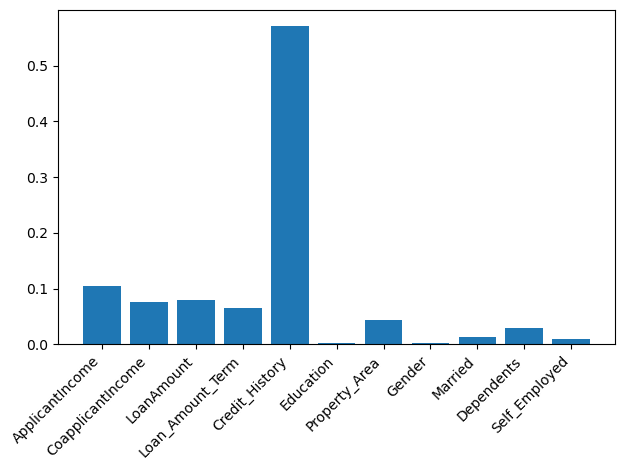

In [66]:
plt.bar(X_train_imputed.columns, model_rf.feature_importances_)
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.show()

In [67]:
scores_rf = cross_val_score(model_rf, X_train_imputed, y_train_encoded, cv=5, scoring='accuracy')

In [68]:
scores_rf.mean()

0.8023500309214594

In [69]:
precision_score(y_test_encoded, y_predicted, average='weighted')

0.8071749940800379

In [75]:
# unique_in_train = X_train_imputed_scaled.shape[0]
# unique_in_test = X_test_imputed_scaled.shape[0]
# unique_in_train_test = len(np.unique(np.vstack((X_train_imputed_scaled, X_test_imputed_scaled)), axis=0))

# print(f"Unique in train: {unique_in_train}, Unique in test: {unique_in_test}, Combined unique: {unique_in_train_test}")